In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import datetime as date

In [50]:

def date_converter(value):
    return pd.to_datetime(value)

In [51]:
# chunk_list = []
trainingData = pd.read_csv('training.csv',
                           converters={'EventTime': date_converter})
#     chunk_list.append(chunk)
# testingData = pd.concat('chunk_list')
# trainingData

In [72]:
trainingData.count()
trainingData.nunique()
trainingData

,EventTime,Measure,Class
0,2020-08-17 18:30:00,269,NaN
1,2020-08-17 18:40:00,380,NaN
2,2020-08-17 18:50:00,386,NaN
3,2020-08-17 19:00:00,376,NaN
4,2020-08-17 19:10:00,374,NaN
...,...,...,...
24995,2021-02-07 18:20:00,568,NaN
24996,2021-02-07 18:30:00,570,NaN
24997,2021-02-07 18:40:00,564,NaN
24998,2021-02-07 18:50:00,583,NaN


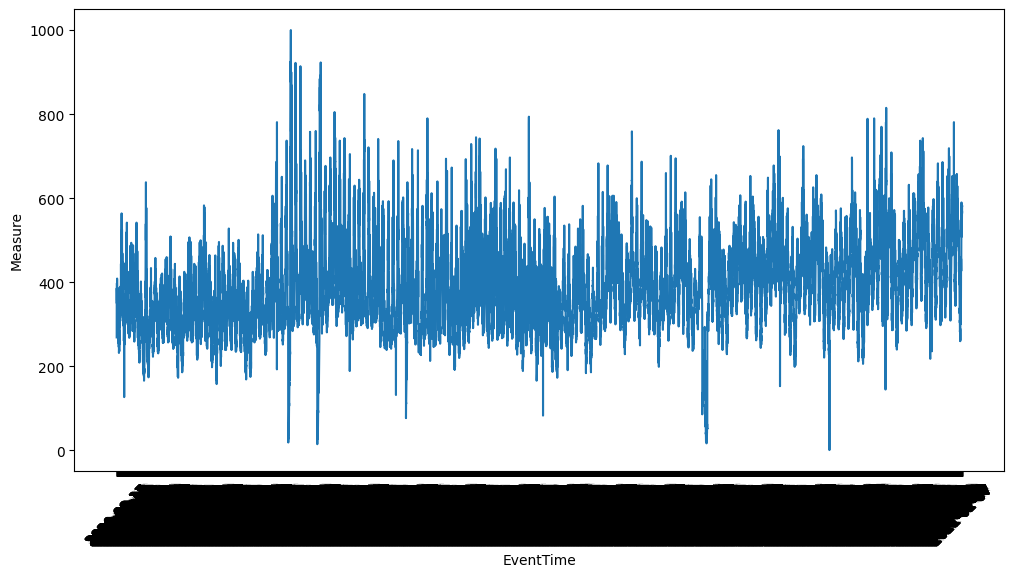

In [65]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=trainingData, x='EventTime', y='Measure')
plt.xticks(trainingData['EventTime'][::1], rotation=45)
plt.show()

In [106]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

trainingArray =  np.array([i for i in trainingData.iloc[:, 1]])
trainingArray

scaler = StandardScaler()
z_scores = scaler.fit_transform(trainingArray.reshape(-1, 1))
z_scores

trainingData['z_scores'] = scaler.fit_transform(trainingData['Measure'].values.reshape(-1, 1))
trainingData

,EventTime,Measure,Class,z_scores
0,2020-08-17 18:30:00,269,NaN,-1.132354
1,2020-08-17 18:40:00,380,NaN,-0.066060
2,2020-08-17 18:50:00,386,NaN,-0.008422
3,2020-08-17 19:00:00,376,NaN,-0.104485
4,2020-08-17 19:10:00,374,NaN,-0.123697
...,...,...,...,...
24995,2021-02-07 18:20:00,568,NaN,1.739915
24996,2021-02-07 18:30:00,570,NaN,1.759128
24997,2021-02-07 18:40:00,564,NaN,1.701490
24998,2021-02-07 18:50:00,583,NaN,1.884009


,EventTime,Measure,Class,z_scores,S class,S_class
0,2020-08-17 18:30:00,269,NaN,-1.132354,True,True
1,2020-08-17 18:40:00,380,NaN,-0.066060,False,True
2,2020-08-17 18:50:00,386,NaN,-0.008422,False,True
3,2020-08-17 19:00:00,376,NaN,-0.104485,False,True
4,2020-08-17 19:10:00,374,NaN,-0.123697,False,True
...,...,...,...,...,...,...
24995,2021-02-07 18:20:00,568,NaN,1.739915,False,False
24996,2021-02-07 18:30:00,570,NaN,1.759128,False,False
24997,2021-02-07 18:40:00,564,NaN,1.701490,False,False
24998,2021-02-07 18:50:00,583,NaN,1.884009,False,False


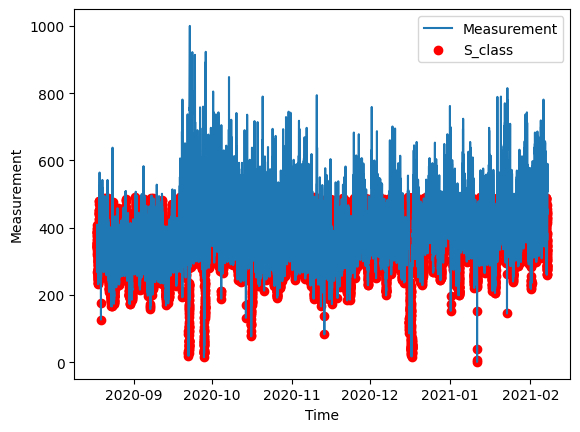

In [113]:
import matplotlib.pyplot as plt

threshols
trainingData['S_class'] = trainingData['z_scores'] < threshold
anomalies = z_scores > threshold
display(trainingData)

plt.plot(trainingData['EventTime'], trainingData['Measure'], label='Measurement')
plt.scatter(trainingData['EventTime'][trainingData['S_class']], trainingData['Measure'][trainingData['S_class']], c='red', label='S_class')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()


In [84]:
import numpy as np
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans

# Load a sample time series dataset (you can replace this with your own data)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("trainingData")
timestamps = trainingData['EventTime']
time_index = (timestamps - timestamps.iloc[0]).dt.total_seconds().values
# TrainStamps_index = np.arange(trainingData['EventTime'])
features = trainingData.drop(columns=['EventTime', 'Class'])
features = features.apply(pd.to_numeric, errors='coerce')
print(features)
X_train = np.column_stack((time_index, features))
print(X_train)
# Normalize the time series data using mean and variance scaling
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

# Define the number of clusters
n_clusters = 5

# Initialize the TimeSeriesKMeans model with DTW metric
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",  verbose=True, random_state=0) # CPU Cluster Parameter: n_jobs=-1,

# Fit the model to the data
model.fit(X_train)

# Get cluster labels
cluster_labels = model.labels_

# Visualize the clusters (for simplicity, we'll plot the first two dimensions if available)
if X_train.shape[2] >= 2:
    plt.figure(figsize=(12, 6))
    for cluster_label in range(n_clusters):
        plt.scatter(
            X_train[cluster_labels == cluster_label, 0, 0],
            X_train[cluster_labels == cluster_label, 0, 1],
            label=f"Cluster {cluster_label}",
        )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title("Cluster Visualization")
    plt.show()
else:
    print("Unable to visualize clusters with fewer than 2 dimensions.")

# Print cluster assignments
for i in range(n_clusters):
    print(f"Cluster {i}:")
    cluster_indices = np.where(cluster_labels == i)[0]


       Measure
0          269
1          380
2          386
3          376
4          374
...        ...
24995      568
24996      570
24997      564
24998      583
24999      582

[25000 rows x 1 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.1s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.1s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    8.9s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.0s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    8.9s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.2s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    8.9s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    8.9s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.0s finished


Resumed because of empty cluster


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 25000 out of 25000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 75000 out of 75000 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Resumed because of empty cluster
Unable to visualize clusters with fewer than 2 dimensions.
Cluster 0:
Cluster 1:
Cluster 2:
Cluster 3:
Cluster 4:


[Parallel(n_jobs=1)]: Done 125000 out of 125000 | elapsed:    9.3s finished


In [ ]:
## Finding the optimal minima and maxima for tomorrow
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from sklearn.preprocessing import StandardScaler

# Example data as a numpy array
data = np.array([value1, value2, value3, ...])

# Create a DataFrame with a timestamp column (adjust as needed)
timestamps = pd.date_range(start='2023-01-01', periods=len(data), freq='H')
df = pd.DataFrame({'timestamp': timestamps, 'measurement': data})

# Split your data into training and validation sets
# For example, use the first 80% of data for training and the remaining 20% for validation
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:]

# Create a threshold range to explore
threshold_range = np.linspace(1.0, 5.0, num=20)  # Adjust the range as needed

# Define the scoring metric (e.g., precision)
scoring_metric = make_scorer(precision_score)

# Initialize the StandardScaler
scaler = StandardScaler()

# Define a function to evaluate the model with a given threshold
def evaluate_threshold(threshold):
    # Calculate Z-scores for the training data
    train_data['z_score'] = scaler.fit_transform(train_data['measurement'].values.reshape(-1, 1))

    # Identify anomalies using the threshold
    train_data['is_anomaly'] = train_data['z_score'] > threshold

    # Calculate precision on the validation data
    val_data['z_score'] = scaler.transform(val_data['measurement'].values.reshape(-1, 1))
    val_data['is_anomaly'] = val_data['z_score'] > threshold
    precision = precision_score(val_data['is_anomaly'], val_data['is_anomaly'])

    return precision

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=None, param_grid={'threshold': threshold_range}, scoring=scoring_metric, cv=5)
grid_search.fit(train_data[['measurement']], train_data['is_anomaly'])

# Get the best threshold
best_threshold = grid_search.best_params_['threshold']
best_precision = grid_search.best_score_

print(f'Best Threshold: {best_threshold}')
print(f'Best Precision: {best_precision}')
